In [347]:
#test_guass
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
import pandas as pd

In [348]:
def gauss(m, x):
    #get y=a+b*exp((x-x0)^2/2sig^2)
    a=m[0]
    b=m[1]
    x0=m[2]
    sig=m[3]
    expvec=np.exp(-0.5*(x-x0)**2/sig**2)
    y=a+b*expvec
    return y

def derivative(m, x, func = gauss, d = 1E-2): 
    #I can further change this function to include the best dx - 4*int(1E5) is the best number I found so far
    #m is the list of params 
    #z is the redshift range
    #y is the brightness temp
    m = np.array(m)
    y = func(m , x)
    derivs = np.zeros([len(x), len(m)])
    dpars = d * m
    dpars = np.array(dpars, copy=True, dtype = 'float64')
    for i in range(len(m)):        
        pars_plus = np.array(m, copy=True, dtype = 'float64')
        pars_plus[i] = pars_plus[i] + dpars[i]
        
        pars_minus = np.array(m, copy=True, dtype = 'float64')
        pars_minus[i] = pars_minus[i] - dpars[i]
        
        A_plus = func(pars_plus , x)
        A_minus = func(pars_minus , x)
        A_m = (A_plus - A_minus)/(2*dpars[i])
        derivs[:, i] = A_m    
    return y, derivs

def update_lamda(lamda, success):
    if success:
        lamda = lamda/1.5
        if lamda<0.5:
            lamda=0
    else:
        if lamda==0:
            lamda=1
        else:
            lamda = lamda*1.5**2
            #lamda = lamda*2
    return lamda

def get_matrices(m, fun, x, y, Ninv):
    model, derivs = fun(m, x)
    r = y-model
    lhs = derivs.T@Ninv@derivs
    rhs = derivs.T@(Ninv@r)
    chisq = r.T@Ninv@r
    return chisq, lhs, rhs

def linv(mat, lamda):
    mat = mat + lamda*np.diag(np.diag(mat))
    return np.linalg.inv(mat)

def LM(m, fun, x, y, Ninv, niter=10, chitol= 1): 
    lamda=0
    #m = check_limits_lm(m)
    chisq, lhs, rhs = get_matrices(m, fun, x, y, Ninv)
    
    for i in range(niter):
        lhs_inv = linv(lhs, lamda)
        dm = lhs_inv@rhs
        m_new = m+dm
        #print(dm)
        #m_new = check_limits_lm(m+dm)
        chisq_new, lhs_new, rhs_new = get_matrices(m_new, fun, x, y, Ninv)

        #try:
         #   chisq_new, lhs_new, rhs_new = get_matrices(m+dm, fun, x, y, Ninv)
        #except:
            
        if chisq_new<chisq:  
            if lamda==0:
                if (np.abs(chisq-chisq_new)<chitol):
                    print('Converged after ', i, ' iterations of LM')
                    return m_new
            chisq = chisq_new
            lhs = lhs_new
            rhs = rhs_new
            m = m_new
            lamda = update_lamda(lamda,True)
            
        else:
            lamda = update_lamda(lamda, False)
        #print('on iteration ', i, ' chisq is ', chisq, ' with step ', dm, ' and lamda ', lamda)
        print('\n', 'on iteration ', i, ' chisq is ', chisq, ' and lamda is ', lamda)
        #print('step ', dm)
        #print('new params ', m_new)
                
    return m


def draw_samples(covariance_matrix, nset):
    #normalizing the covariance matrix
    D = np.diag(np.diag(covariance_matrix)) #diagonal matrix of covariance matrix
    D_sqrt = np.sqrt(D)
    D_inv_sqrt = np.linalg.pinv(D_sqrt)
    covariance_matrix_normalized = D_inv_sqrt @ covariance_matrix @ D_inv_sqrt #normalized covariance matrix

    e,v = np.linalg.eigh(covariance_matrix_normalized)
    e[e<0]=0 #make sure we don't have any negative eigenvalues due to roundoff
    n = len(e)

    #make gaussian random variables
    g=np.random.randn(n, nset)

    #now scale them by the square root of the eigenvalues
    rte=np.sqrt(e)
    for i in range(nset):
        g[:,i]=g[:,i]*rte

    #and rotate back into the original space
    samples = (v@g).T
    samples_denormalized = samples @ D_sqrt
    return samples_denormalized


def chisquare (pars, data, Ninv): #returns the chi-square of two 21cm curves - err can be a number/array   
    pred = gauss(pars, x)
    r = data-pred
    chisq = r.T@Ninv@r
    return chisq

#Defining the MCMC chain
def mcmc(fun_chisq, start_guess, covariance_matrix, data, Ninv, nstep):
    samples = draw_samples(covariance_matrix, nstep)

    #definig the chain
    chain = np.empty((nstep, len(start_guess)))
    chain[0, :] = start_guess
     
    #defining the chi-square array
    chisq = np.zeros(nstep)
    chisq[0] = fun_chisq(start_guess, data, Ninv)

    #defining the acceptance ratio
    acceptance_ratio = 0
            
    #the chain 
    for i in range(1, nstep):
        #print('iteration number', i, 'of', nstep) 
        new_param = samples[i, :] + chain[i-1, :]
        new_chisq =  fun_chisq(new_param, data, Ninv)
        
        #try:
        #    new_chisq =  fun_chisq(new_param, data, err)
        #except:
        #    new_chisq = 1E7
      
        if new_chisq <= chisq[i-1]:
            acceptance_ratio = acceptance_ratio + 1
            chisq[i] = new_chisq
            chain[i, :] = new_param 
        else :
            betta = 0.5
            if np.random.rand(1)<betta*(np.exp(-0.5*(new_chisq-chisq[i-1]))):
                acceptance_ratio = acceptance_ratio + 1
                chisq[i] = new_chisq
                chain[i, :] = new_param
            else:
                chisq[i] = chisq[i-1]
                chain[i, :] = chain[i-1, :]          
    return chain, chisq, acceptance_ratio/nstep

you need to put error dependant on the value of datapoint itself.
Then, form the noise matrix
for exaple: 10 percent on the value of data!

In [349]:
m_true = [1.0, 2.0, 50.0, 2.0]
m_true = np.array(m_true, copy=True, dtype = 'float64')
x = np.linspace(1, 100, 100)
y_true = gauss(m_true, x)
m_0 = m_true * (1 +  0.1* np.random.randn(len(m_true)))
err = 1E-3
Ninv = ((err)**(-2))*np.eye(len(x))

In [350]:
m_fit = LM (m_0, derivative, x, y_true, niter=20, Ninv = Ninv)
chisq_f, lhs_f, rhs_f = get_matrices(m_fit, derivative, x, y_true, Ninv)
mycov = lhs_f
y_fit, derivs = derivative(m_fit, x)


 on iteration  0  chisq is  8835438.078624237  and lamda is  0

 on iteration  1  chisq is  8835438.078624237  and lamda is  1

 on iteration  2  chisq is  5976168.182911642  and lamda is  0.6666666666666666

 on iteration  3  chisq is  3199754.6557154534  and lamda is  0

 on iteration  4  chisq is  3199754.6557154534  and lamda is  1

 on iteration  5  chisq is  1746981.3947364013  and lamda is  0.6666666666666666

 on iteration  6  chisq is  675759.5199905119  and lamda is  0

 on iteration  7  chisq is  78334.6817479395  and lamda is  0

 on iteration  8  chisq is  49.8265425061725  and lamda is  0

 on iteration  9  chisq is  5.210397386719523e-05  and lamda is  0
Converged after  10  iterations of LM


The first element of the diagonal of inverse of the covariance matrix related to a gaussian which shows the background (shift parameter), can give us a hint if our covariance matrix is true. 
We know that the error bar of this parameter is err/sqrt(# samples), so when error is 10^-2, which approximately a hundred data points, the error bar will be 10^-2/sqrt(100)=10^-3

In [351]:
mycovinv= np.linalg.inv(mycov)
np.sqrt(np.diag(mycovinv))

array([0.00010578, 0.0006548 , 0.00076289, 0.00076593])

step size ~error bar

In [352]:
n = 10000
samples = draw_samples(mycovinv, n)
print(np.std((samples.T@samples)/n - mycovinv))
#print(samples.T@samples/n)
#print(mycovinv)
csq= np.empty(n)
samples_with_mean= np.empty((n , 4))

for i in range(n):
    samples_with_mean[i, :] = samples[i, :] + m_fit
    csq[i] = chisquare(samples_with_mean[i, :], y_true, Ninv)

csq_mean= np.mean(csq)
csq_diff = csq - chisq_f
print(np.mean(csq_diff))

2.693396637808832e-09
4.06309595128394


In [353]:
m_fit

array([ 1.,  2., 50.,  2.])

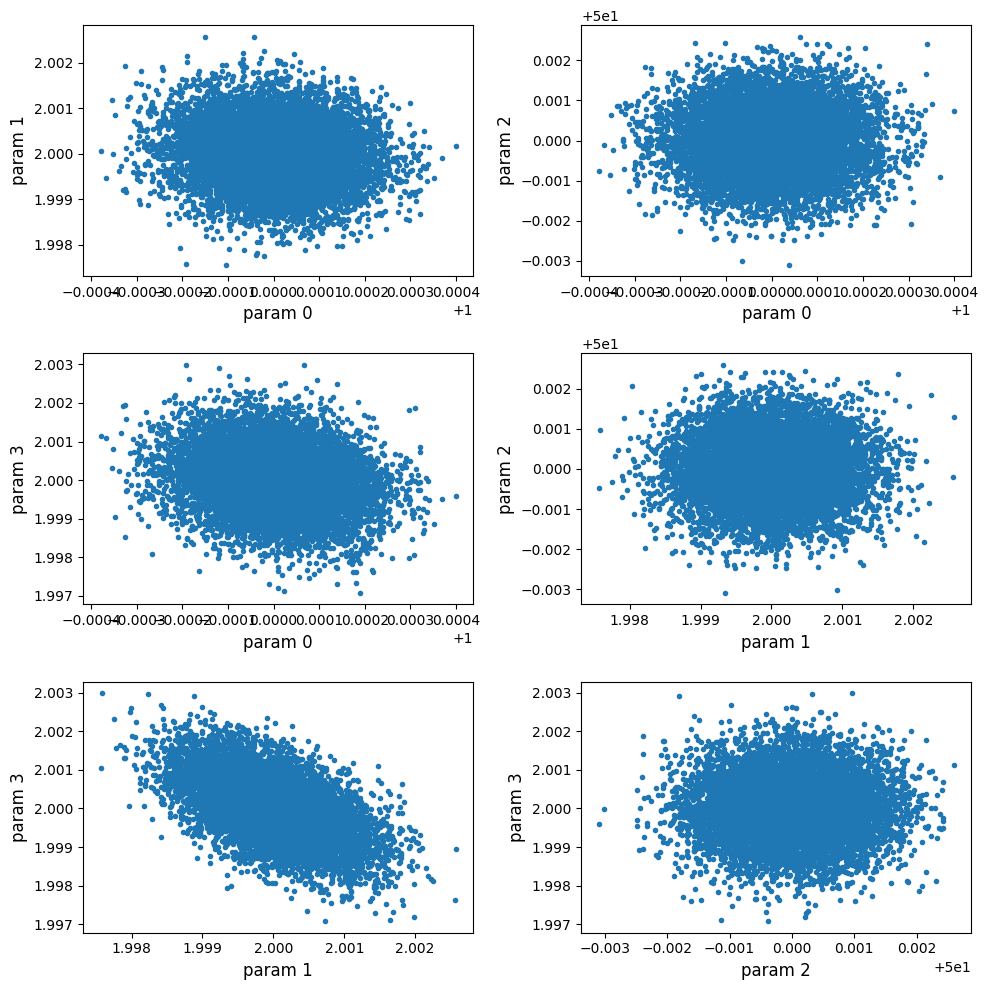

In [354]:
params_cut = np.copy(samples_with_mean)
fig, ax_list = plt.subplots(3, 2, figsize=(10,10))
#fig.suptitle('Corner plots of the chain', fontsize=16)

ax_list[0, 0].plot(params_cut[:, 0], params_cut[:, 1], linestyle = "", marker=".")
ax_list[0, 0].set_ylabel('param 1', fontsize=12)
ax_list[0, 0].set_xlabel('param 0', fontsize=12)

ax_list[0, 1].plot(params_cut[:, 0], params_cut[:, 2], linestyle = "", marker=".")
ax_list[0, 1].set_ylabel('param 2', fontsize=12)
ax_list[0, 1].set_xlabel('param 0', fontsize=12)
    
ax_list[1, 0].plot(params_cut[:, 0], params_cut[:, 3], linestyle = "", marker=".")
ax_list[1, 0].set_ylabel('param 3', fontsize=12)
ax_list[1, 0].set_xlabel('param 0', fontsize=12)

ax_list[1, 1].plot(params_cut[:, 1], params_cut[:, 2], linestyle = "", marker=".")
ax_list[1, 1].set_ylabel('param 2', fontsize=12)
ax_list[1, 1].set_xlabel('param 1', fontsize=12)

ax_list[2, 0].plot(params_cut[:, 1], params_cut[:, 3], linestyle = "", marker=".")
ax_list[2, 0].set_ylabel('param 3', fontsize=12)
ax_list[2, 0].set_xlabel('param 1', fontsize=12)

ax_list[2, 1].plot(params_cut[:, 2], params_cut[:, 3], linestyle = "", marker=".")
ax_list[2, 1].set_ylabel('param 3', fontsize=12)
ax_list[2, 1].set_xlabel('param 2', fontsize=12)

plt.tight_layout()
plt.show()

why does the difference in chi-squares need to be of order 1? Cause some samples are very separated fron the m_fit. Thus, their chi-sqaures are way higher.
I need to figure out why this test is true. I yet do not know that.

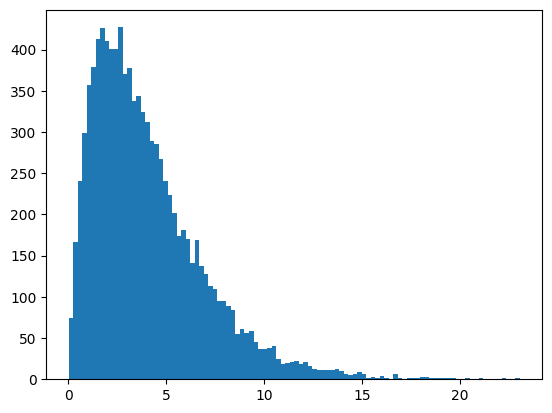

In [355]:
#plt.plot(csq_diff, linestyle = "", marker=".")
plt.hist(csq_diff, bins=100)
plt.show()

In [356]:
#MCMC inputs 
param_length = len(m_true)
nstep = 10000

In [357]:
#Running the MCMC
params, cs, acceptance_ratio = mcmc(chisquare, m_fit, mycovinv, y_true, Ninv, nstep)

#MCMC output
mcmc_param= np.empty(param_length)
for i in range(param_length):
    mcmc_param[i] = np.mean(params[:,i]) #array of best parameters  
mcmc_T = gauss(mcmc_param, x) #best fit curve

In [358]:
print('Chi-Square of original guess: ', chisquare(m_0, y_true, Ninv))
print('Chi-Square of LM:', chisquare(m_fit, y_true, Ninv))
print('Chi-Square of MCMC: ', chisquare(mcmc_param, y_true, Ninv))
print('Acceptance Ratio: ', acceptance_ratio*100, '%')

Chi-Square of original guess:  13541083.620860614
Chi-Square of LM: 3.0155602011807156e-13
Chi-Square of MCMC:  0.004235836653147423
Acceptance Ratio:  23.73 %


In [359]:
mcmc_param

array([ 1.00000087,  2.00001119, 49.99997186,  1.99996064])

In [360]:
m_fit

array([ 1.,  2., 50.,  2.])

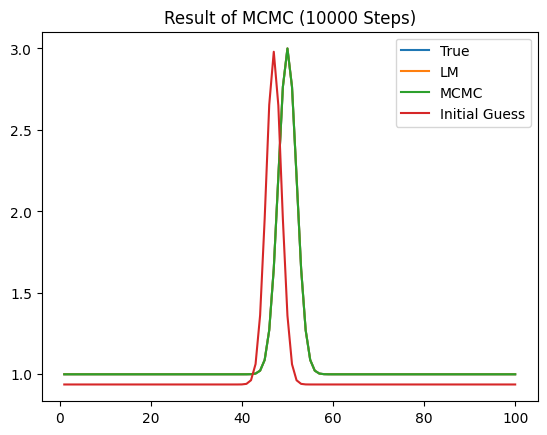

In [361]:
plt.plot(x, y_true, label = 'True')
plt.plot(x, y_fit, label = 'LM')
plt.plot(x, mcmc_T, label = 'MCMC')
plt.plot(x, gauss(m_0, x), label = 'Initial Guess')
plt.legend()
plt.title('Result of MCMC (%d Steps)'%nstep, fontsize=12)
plt.show()

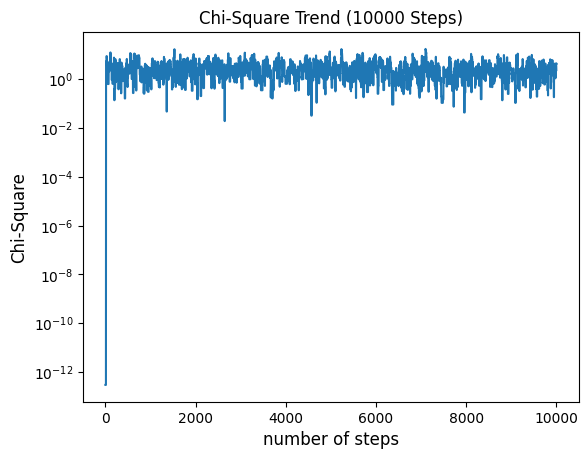

In [362]:
#Plotting the chi-square trend
fig3 = plt.figure()
#plt.plot(np.log(cs))
plt.semilogy(cs)
plt.xlabel('number of steps', fontsize=12)
plt.title ('Chi-Square Trend (%d Steps)'%nstep, fontsize=12)
plt.ylabel('Chi-Square', fontsize=12)
plt.show()

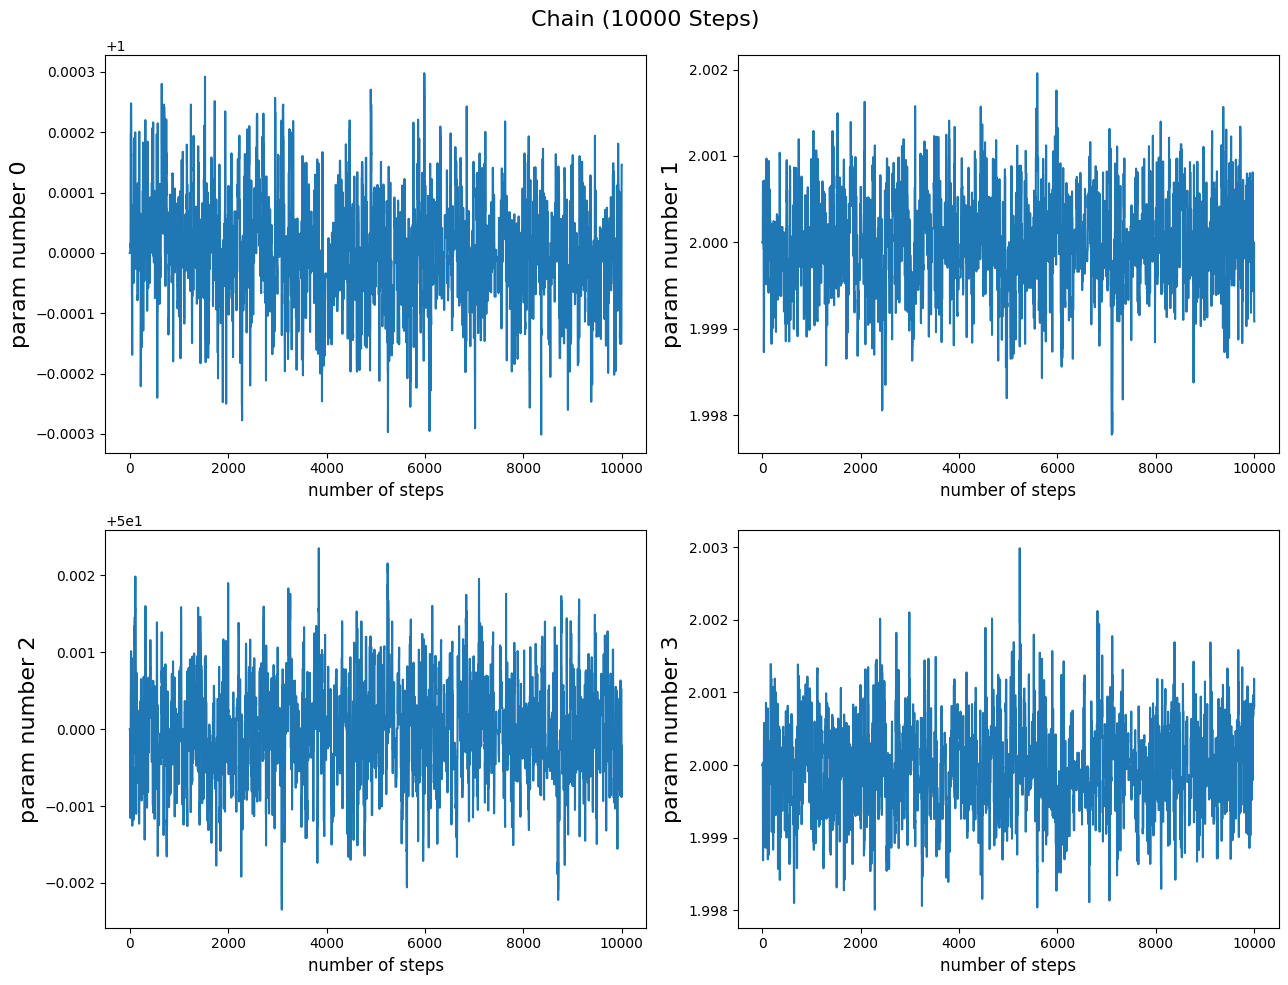

In [363]:
fig4, ax_list = plt.subplots(ceil(param_length/2), 2, figsize=(13,10))
fig4.suptitle('Chain (%d Steps)'%nstep, fontsize=16)
#fig4.suptitle('Displaying The Trend of Parameters', fontsize=16)
if((param_length % 2) == 0):
    for i in range(ceil(param_length/2)):
        for j in range(2):
            ax_list[i, j].plot(params[:, i*2+ j])
            #ax_list[i, j].set_ylabel(repr(key[i*2+ j]), fontsize=16)
            ax_list[i, j].set_ylabel('param number %d'%(i*2+ j), fontsize=16)
            ax_list[i, j].set_xlabel('number of steps', fontsize=12)

else:
    for i in range(ceil(param_length/2)):
        for j in range(2):
            if(j == 1 and i == (ceil(param_length/2)-1)):
                break
            ax_list[i, j].plot(params[:, i*2+ j])
            #ax_list[i, j].set_ylabel(repr(key[i*2+ j]), fontsize=16)
            ax_list[i, j].set_ylabel('param number %d'%(i*2+ j), fontsize=16)
            ax_list[i, j].set_xlabel('number of steps', fontsize=12)
            

plt.tight_layout()
plt.show()

In [364]:
#Fourier Transform
ps = np.zeros((nstep, param_length))
for i in range(param_length):
    ps[:, i] = np.abs(np.fft.fft(params[:, i]))**2
    
freqs = np.fft.rfftfreq(nstep)
idx = np.argsort(freqs)

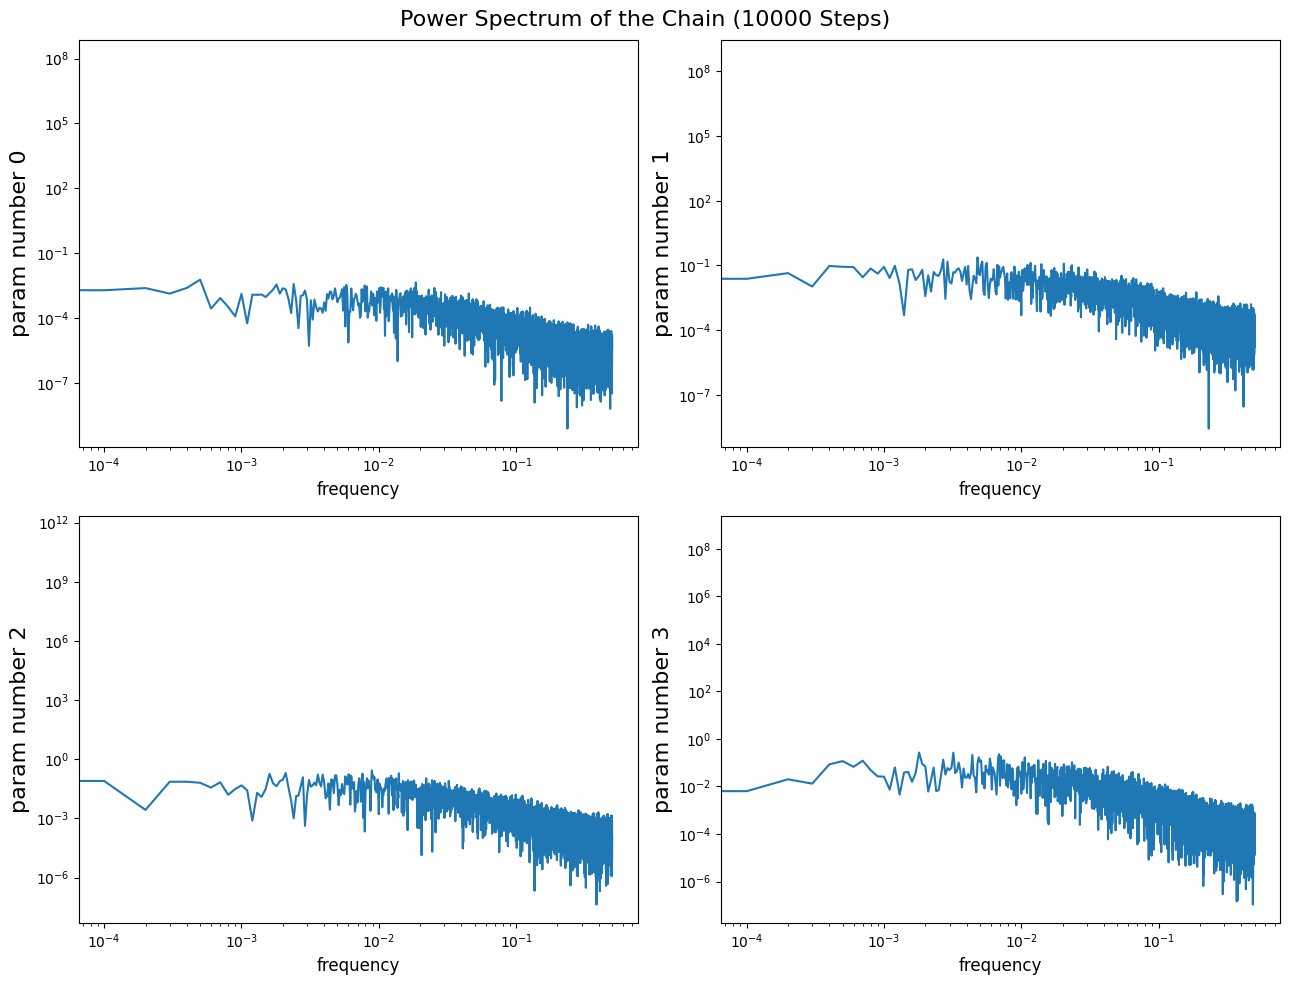

In [365]:
fig4, ax_list = plt.subplots(ceil(param_length/2), 2, figsize=(13,10))
fig4.suptitle('Power Spectrum of the Chain (%d Steps)'%nstep, fontsize=16)
if((param_length % 2) == 0):
    for i in range(ceil(param_length/2)):
        for j in range(2):
            ax_list[i, j].loglog(freqs[idx], ps[idx, i*2+ j])
            #plt.yscale("log")
            #ax_list[i, j].set_ylabel(repr(key[i*2+ j]), fontsize=16)
            ax_list[i, j].set_ylabel('param number %d'%(i*2+ j), fontsize=16)
            ax_list[i, j].set_xlabel('frequency', fontsize=12)
            #ax_list[i, j].set_ylim(0, 1E2)
            #ax_list[i, j].set_xlim(0.2, 0.5)

else:
    for i in range(ceil(param_length/2)):
        for j in range(2):
            if(j == 1 and i == (ceil(param_length/2)-1)):
                break
            ax_list[i, j].loglog(freqs[idx], ps[idx, i*2+ j])
            #plt.yscale("log")
            ax_list[i, j].set_ylabel('param number %d'%(i*2+ j), fontsize=16)
            ax_list[i, j].set_xlabel('frequency', fontsize=12)
            #ax_list[i, j].set_ylim(0, 1E2)
            #ax_list[i, j].set_xlim(0.2, 0.5)
            
            

plt.tight_layout()
plt.show()

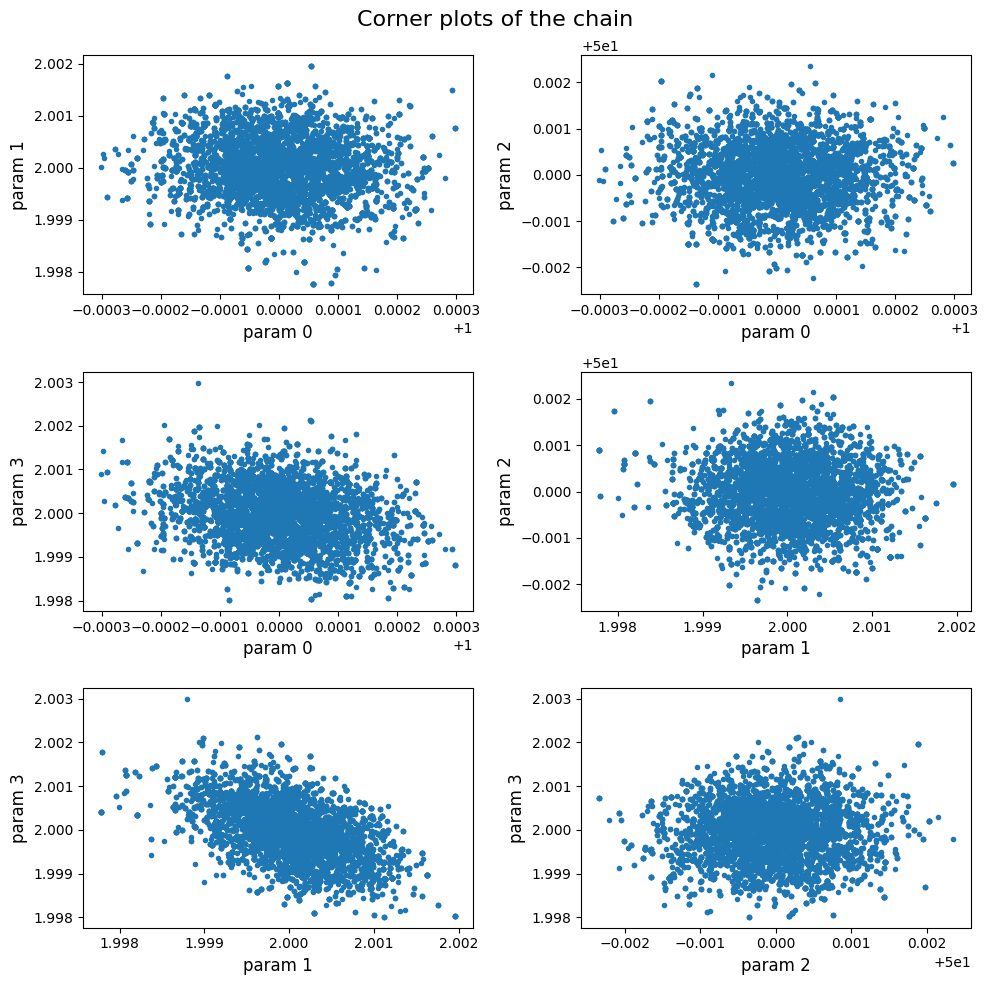

In [366]:
#params_cut = params[1000:, :]
params_cut = np.copy(params)
fig, ax_list = plt.subplots(3, 2, figsize=(10,10))
fig.suptitle('Corner plots of the chain', fontsize=16)

ax_list[0, 0].plot(params_cut[:, 0], params_cut[:, 1], linestyle = "", marker=".")
ax_list[0, 0].set_ylabel('param 1', fontsize=12)
ax_list[0, 0].set_xlabel('param 0', fontsize=12)

ax_list[0, 1].plot(params_cut[:, 0], params_cut[:, 2], linestyle = "", marker=".")
ax_list[0, 1].set_ylabel('param 2', fontsize=12)
ax_list[0, 1].set_xlabel('param 0', fontsize=12)
    
ax_list[1, 0].plot(params_cut[:, 0], params_cut[:, 3], linestyle = "", marker=".")
ax_list[1, 0].set_ylabel('param 3', fontsize=12)
ax_list[1, 0].set_xlabel('param 0', fontsize=12)

ax_list[1, 1].plot(params_cut[:, 1], params_cut[:, 2], linestyle = "", marker=".")
ax_list[1, 1].set_ylabel('param 2', fontsize=12)
ax_list[1, 1].set_xlabel('param 1', fontsize=12)

ax_list[2, 0].plot(params_cut[:, 1], params_cut[:, 3], linestyle = "", marker=".")
ax_list[2, 0].set_ylabel('param 3', fontsize=12)
ax_list[2, 0].set_xlabel('param 1', fontsize=12)

ax_list[2, 1].plot(params_cut[:, 2], params_cut[:, 3], linestyle = "", marker=".")
ax_list[2, 1].set_ylabel('param 3', fontsize=12)
ax_list[2, 1].set_xlabel('param 2', fontsize=12)

plt.tight_layout()
plt.show()

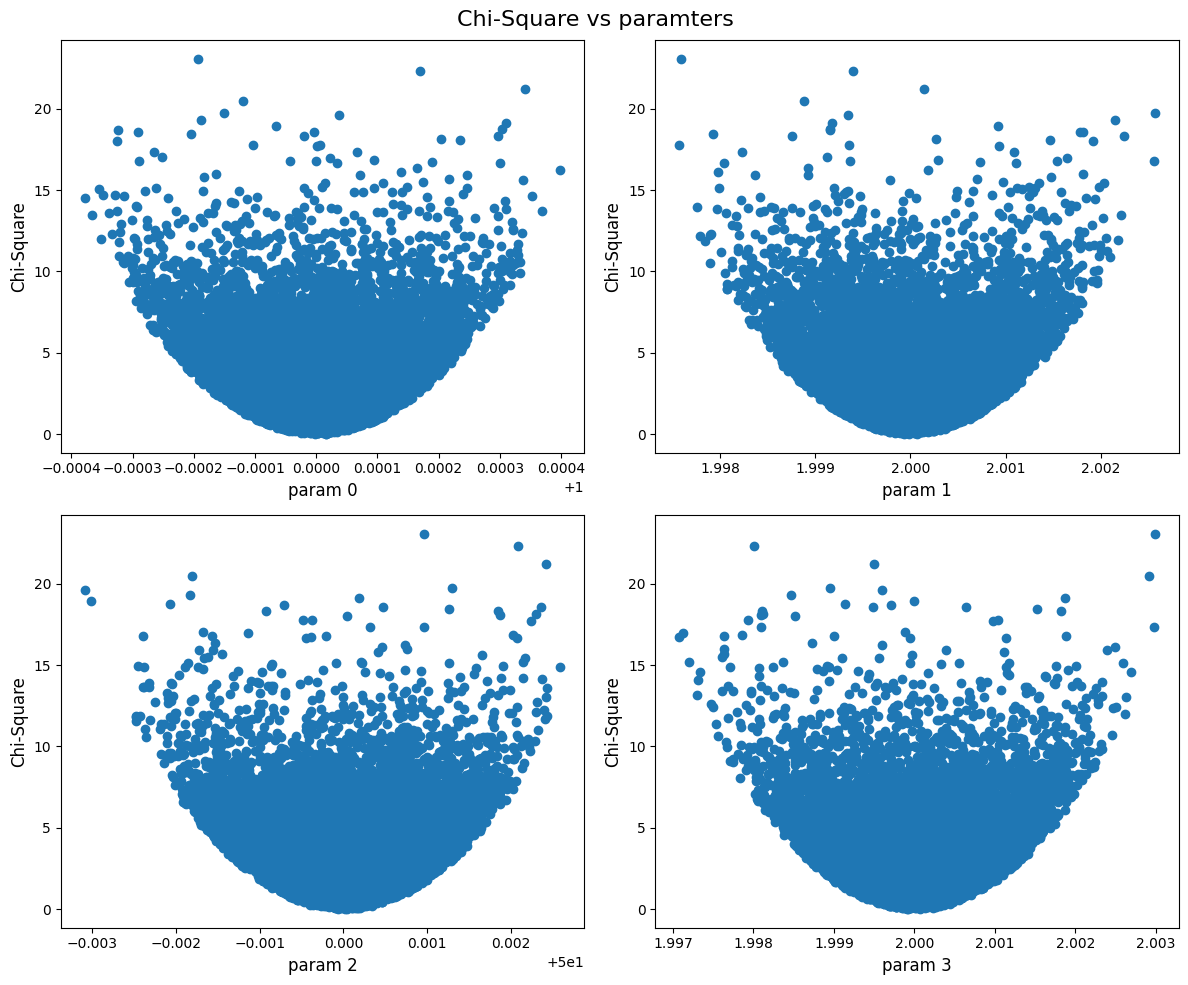

In [367]:
fig, ax_list = plt.subplots(2, 2, figsize=(12,10))
fig.suptitle('Chi-Square vs paramters', fontsize=16)

ax_list[0, 0].scatter(samples[:, 0]+ m_true[0], csq)
ax_list[0, 0].set_ylabel('Chi-Square', fontsize=12)
ax_list[0, 0].set_xlabel('param 0', fontsize=12)

ax_list[0, 1].scatter(samples[:, 1]+m_true[1], csq)
ax_list[0, 1].set_ylabel('Chi-Square', fontsize=12)
ax_list[0, 1].set_xlabel('param 1', fontsize=12)

ax_list[1, 0].scatter(samples[:, 2]+m_true[2], csq)
ax_list[1, 0].set_ylabel('Chi-Square', fontsize=12)
ax_list[1, 0].set_xlabel('param 2', fontsize=12)

ax_list[1, 1].scatter(samples[:, 3]+m_true[3], csq)
ax_list[1, 1].set_ylabel('Chi-Square', fontsize=12)
ax_list[1, 1].set_xlabel('param 3', fontsize=12)

plt.tight_layout()
plt.show()

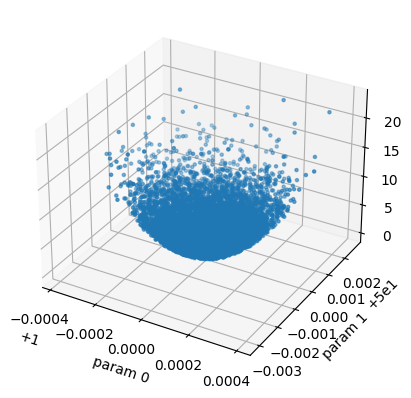

In [368]:
#%matplotlib qt 
fig1 = plt.figure()
ax = plt.axes(projection='3d')
#ax.set_title('accessible regions of param space')
ax.set_xlabel('param 0')
ax.set_ylabel('param 1')
ax.set_zlabel('Chi-Square')
ax.scatter3D(samples[:, 0]+ m_true[0], samples[:, 2]+ m_true[2], csq, marker= '.')